<div class="output_png output_subarea output_execute_result">
<center>
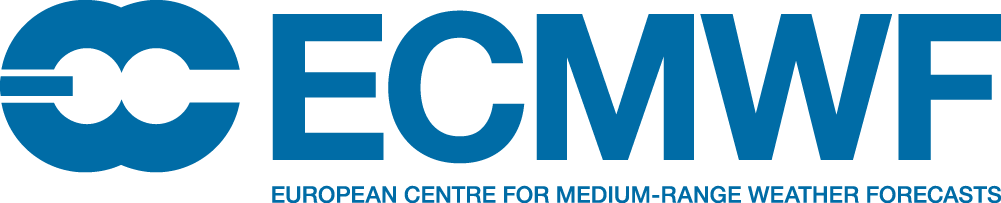</center>
</div>

# 	Mean sea level pressure and wind speed at 850 hPa

This notebook will provide you guidance how to explore and plot ECMWF open dataset to produce the map from the ECMWF open charts web product.  
The original product can be found on this link: https://apps.ecmwf.int/webapps/opencharts/products/medium-mslp-wind850

Access to ECMWF Open data is governed by the following [Terms of Use](https://apps.ecmwf.int/datasets/licences/general/).    

To find out how to obtain the access to the full forecast dataset at higher resolution please visit our [Access page](https://www.ecmwf.int/en/forecasts/accessing-forecasts).

## Retrieve Data
This product takes in input 3 parameters :

* [Mean sea level pressure](https://apps.ecmwf.int/codes/grib/param-db/?id=151)
* [U component of wind](https://apps.ecmwf.int/codes/grib/param-db/?id=131)
* [V component of wind](https://apps.ecmwf.int/codes/grib/param-db/?id=132)

In this example, we will use: 
- **ecmwf.opendata** Client to download the data
- **ecmwf.data** library to read and process the data (calculate the speed and shear)
- **ecmwf.geomaps** to plot the result

First we need to install them in the current Jupyter kernel:  
<div class="alert alert-block alert-info">
<b>Note:</b> Skip this cell if you already have these libraries installed
</div>

In [ ]:
import sys
!{sys.executable} -m pip install ecmwf-data ecmwf-opendata git+https://github.com/ecmwf/ecmwf-geomaps.git

In [1]:
import ecmwf.data as ecdata
from ecmwf.geomaps import GeoMap
from ecmwf.opendata import Client

In [2]:
client = Client("https://ai4edataeuwest.blob.core.windows.net/ecmwf", beta=True)

## Retrieve requests
This product uses parameters at different vertical levels.  
Mean sea level pressure belongs to the surface parameters, while u and v at 850 hPa are pressure level parameters.  
The two types of levels can not be in the same request, so we need to make two requests for them. 

In [3]:
sfc_parameters = ['msl']
pl_parameters = ['u', 'v']
sfc_filename = 'medium-mslp.grib'
pl_filename = 'medium-uv850.grib'

First we retrieve surface parameters (Mean sea level pressure)

In [4]:
client.retrieve(
    date=-2,
    time=0,
    step=12,
    stream="oper",
    type="fc",
    levtype="sfc",
    param=sfc_parameters,
    target=sfc_filename
)

And then u and v wind components on pressure level 850 hPa

In [5]:
client.retrieve(
    date=-2,
    time=0,
    step=12,
    stream="oper",
    type="fc",
    levtype="pl",
    levelist=850,
    param=pl_parameters,
    target=pl_filename
)

## Reading and processing the data
Now we can use **ecmwf.data** to read the files.

In [6]:
wind850 = ecdata.read(pl_filename)
msl = ecdata.read(sfc_filename)

The **describe()** function will give us the overview of the dataset.  

In [7]:
wind850.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
u,isobaricInhPa,850,20220104,0,12,None,131,od,oper,fc,0001
v,isobaricInhPa,850,20220104,0,12,None,132,od,oper,fc,0001


And an overview of one parameter, where we can see more information, such as units or type of level.

In [8]:
msl.describe('msl')

shortName,msl
name,Mean sea level pressure
paramId,151
units,Pa
typeOfLevel,meanSea
level,0
date,20220104
time,0
step,12
number,None
class,od


We can use **ls()** function to list all the fields in the file we downloaded.

In [9]:
wind850.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
Message,,,,,,,,,,
0,ecmf,u,isobaricInhPa,850,20220104,0,12,fc,None,regular_ll
1,ecmf,v,isobaricInhPa,850,20220104,0,12,fc,None,regular_ll


In order to calculate the speed, we need to filter out u and v component and use the **speed()** function for the calculation.

In [10]:
u = wind850.select(shortName ='u')
v = wind850.select(shortName ='v')
speed = ecdata.speed(u,v)
speed.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
ws,isobaricInhPa,850,20220104,0,12,None,10,od,oper,fc,0001


And finally, we can plot the data on the map. 

Magics-warning: description is not a known keyword


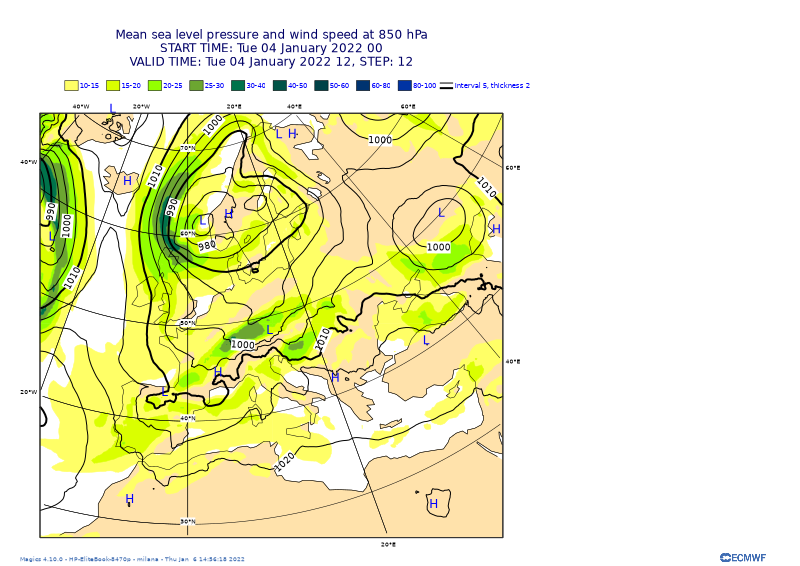

In [11]:
fig = GeoMap(area_name='europe', preset='background-foreground')

fig.contour_lines(speed, preset="sh_grn_f10t100lst")
fig.contour_lines(msl, preset="ct_blk_i5_t2_web")

fig.title(["Mean sea level pressure and wind speed at 850 hPa", 
           "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H' where='shortName=msl'/> ",
           "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H' where='shortName=msl'/>, STEP: <grib_info key='step' where='shortName=msl' />"])
fig.show()